# Github Star数量预测

## 一、实验背景
Github star数量可以反映一个开源项目的影响力和受欢迎程度。通过其他指标对star数量进行拟合，可以预测项目star的值，探索github项目的各个特征对star数量的影响。

## 二、实验目标
利用线性回归等机器学习方法,建立模型对Github项目star数量进行预测。

## 三、实验数据
本实验使用的数据集通过pygithub获得，包括了339个pr数量大于0的python仓库。该数据集包含339条数据,每条数据包含仓库名称、star数量、issue关闭数量、issue开启数量等字段。
数据集收集代码如下：
```python
from github import Github
import csv

access_token = "YOUR_GIT_TOKEN" #通过github>Settings>Developer settings>Personal access tokens获取

gh = Github(access_token)
repositories = gh.search_repositories(query='language:python')
star_num = []
topics_num = []
k = 0
data = []
for repo in repositories:
    if k == 500:
        break
    if k%10 == 0:
        print(k)
    repo_data = {
        'repo_name': repo.full_name,
        'stargazers_count': repo.stargazers_count,
        'issue_closed': repo.get_issues(state='closed').totalCount,
        'issue_open': repo.get_issues(state='open').totalCount,
        'issue_label_num': repo.get_labels().totalCount,
        'issue_num': repo.get_issues().totalCount,
        'repo_comments_num': repo.get_comments().totalCount,
        'forks_num': repo.get_forks().totalCount,
        'watchers_num': repo.get_watchers().totalCount,
        'pr_num': repo.get_pulls().totalCount,
    }
    k = k +1
    data.append(repo_data)

csv_file_path = 'repositories_data1.csv'
with open(csv_file_path, mode='w', newline='') as file:
    fieldnames = ['repo_name', 'stargazers_count', 'issue_closed', 'issue_open', 'issue_label_num', 'issue_num', 'repo_comments_num', 'forks_num', 'watchers_num',  'pr_num']  

    writer = csv.DictWriter(file, fieldnames=fieldnames)

    writer.writeheader() 

    for repo_data in data:
        writer.writerow(repo_data)  
```

## 四、实验步骤

1. 导入相关库，加载数据

In [87]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
csv_file_path = 'repositories_data1.csv'
df = pd.read_csv(csv_file_path)
df.head()

,repo_name,stargazers_count,issue_closed,issue_open,issue_label_num,issue_num,repo_comments_num,forks_num,watchers_num,pr_num
0,scikit-learn/scikit-learn,56042,24407,2258,101,2258,2571,24016,40000,631
1,deepfakes/faceswap,47186,1315,24,24,24,57,12559,40000,3
2,isocpp/CppCoreGuidelines,39790,1878,252,10,252,106,5230,39789,18
3,faif/python-patterns,38215,393,13,7,13,7,6695,38214,2
4,donnemartin/data-science-ipython-notebooks,25660,66,33,14,33,3,7214,25658,17


2. 数据概览

In [88]:
df.shape

(339, 10)

In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339 entries, 0 to 338
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   repo_name          339 non-null    object
 1   stargazers_count   339 non-null    int64 
 2   issue_closed       339 non-null    int64 
 3   issue_open         339 non-null    int64 
 4   issue_label_num    339 non-null    int64 
 5   issue_num          339 non-null    int64 
 6   repo_comments_num  339 non-null    int64 
 7   forks_num          339 non-null    int64 
 8   watchers_num       339 non-null    int64 
 9   pr_num             339 non-null    int64 
dtypes: int64(9), object(1)
memory usage: 26.6+ KB


In [90]:
df.describe()

,stargazers_count,issue_closed,issue_open,issue_label_num,issue_num,repo_comments_num,forks_num,watchers_num,pr_num
count,339.000000,339.000000,339.000000,339.00000,339.000000,339.000000,339.000000,339.000000,339.000000
mean,3589.333333,655.935103,95.292035,12.79056,95.292035,21.958702,699.651917,3520.622419,14.678466
std,6139.917384,1782.158978,215.626266,16.33254,215.626266,144.104164,1759.712464,5636.799529,40.847818
min,144.000000,0.000000,1.000000,0.00000,1.000000,0.000000,3.000000,144.000000,1.000000
25%,344.000000,25.500000,10.000000,7.00000,10.000000,0.000000,85.500000,344.000000,2.000000
50%,1814.000000,108.000000,30.000000,9.00000,30.000000,2.000000,251.000000,1814.000000,4.000000
75%,3502.500000,470.500000,95.000000,13.00000,95.000000,10.000000,661.500000,3502.500000,13.000000
max,56042.000000,24407.000000,2258.000000,224.00000,2258.000000,2571.000000,24016.000000,40000.000000,631.000000


3. 特征工程

In [91]:
df = df.drop(columns='repo_name')
df.corr()

,stargazers_count,issue_closed,issue_open,issue_label_num,issue_num,repo_comments_num,forks_num,watchers_num,pr_num
stargazers_count,1.000000,0.569157,0.548543,0.338514,0.548543,0.525924,0.869855,0.990519,0.585040
issue_closed,0.569157,1.000000,0.760189,0.662642,0.760189,0.827581,0.665873,0.506336,0.866478
issue_open,0.548543,0.760189,1.000000,0.502159,1.000000,0.618878,0.637542,0.514284,0.784671
issue_label_num,0.338514,0.662642,0.502159,1.000000,0.502159,0.390875,0.354360,0.320654,0.493876
issue_num,0.548543,0.760189,1.000000,0.502159,1.000000,0.618878,0.637542,0.514284,0.784671
repo_comments_num,0.525924,0.827581,0.618878,0.390875,0.618878,1.000000,0.750555,0.423008,0.853819
forks_num,0.869855,0.665873,0.637542,0.354360,0.637542,0.750555,1.000000,0.810495,0.744499
watchers_num,0.990519,0.506336,0.514284,0.320654,0.514284,0.423008,0.810495,1.000000,0.511288
pr_num,0.585040,0.866478,0.784671,0.493876,0.784671,0.853819,0.744499,0.511288,1.000000


In [92]:
import matplotlib.pyplot as plt
import seaborn as sns

线性回归假设特征之间是相互独立的。如果特征之间存在相关性或依赖关系，可能会导致模型不稳定，难以分离特征对因变量的影响。因此，在应用线性回归模型前，通常要确保特征之间尽可能独立。使用seaborn的heatmap功能绘制特征相关性热力图,根据热力图可视化分析剔除与其他特征相关系数较高的特征:

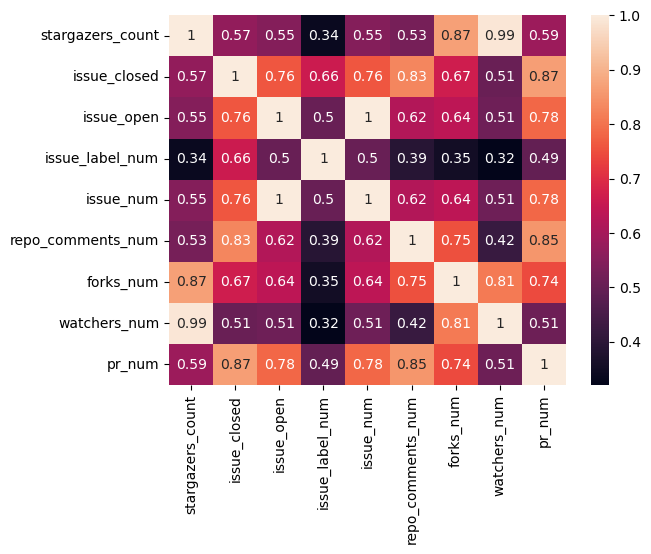

In [93]:
sns.heatmap(df.corr(), annot = True);

4. 划分数据集

使用sklearn的train_test_split将数据划分为训练集和测试集:

In [ ]:
# X = df[['issue_closed', 'issue_open', 'issue_label_num', 'issue_num', 'repo_comments_num', 'forks_num', 'watchers_num',  'pr_num']]
selected_columns = ['issue_open', 'issue_label_num', 'issue_num', 'repo_comments_num', 'forks_num', 'watchers_num']
X = df[selected_columns]
y = df['stargazers_count']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

5. 模型训练

使用线性回归模型sklearn.linear_model.LinearRegression进行模型训练:

In [94]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred

array([9.73539885e+02, 2.79601983e+02, 2.34247761e+02, 8.53238361e+03,
       5.77657745e+02, 1.38682462e+02, 1.72811965e+02, 3.65480061e+01,
       9.48053609e+01, 9.37517455e+03, 5.73100471e+02, 2.89705857e+02,
       1.76837718e+03, 1.74510480e+03, 2.40021828e+02, 1.62722069e+03,
       5.66850764e+02, 1.51266291e+03, 1.89964038e+03, 1.55563068e+04,
       1.31867131e+02, 5.40287568e+03, 1.97245664e+03, 6.30385574e+02,
       1.81333074e+02, 3.24461066e+03, 2.58426993e+02, 2.64341575e+03,
       1.65797759e+02, 1.59855571e+03, 1.42767093e+02, 9.56142638e+03,
       4.57076434e+02, 1.65692927e+03, 4.59874871e+03, 2.74884957e+04,
       8.18567909e+02, 1.38948524e+02, 2.14723864e+02, 4.62812083e+03,
       4.01105983e+03, 3.93861029e+04, 2.09597617e+03, 3.30221521e+02,
       1.03173473e+04, 1.52775320e+03, 8.52703602e+02, 9.74617840e+02,
       4.69394857e+03, 1.23081352e+04, 1.54020222e+03, 2.20128013e+02,
       2.99968018e+03, 3.82055545e+03, 5.46537991e+03, 2.66493543e+03,
      

## 五、实验结果

模型评估：

In [95]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
R2_score = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
def eval_metric(actual, pred):
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    rmse = np.sqrt(mean_squared_error(actual, pred))
    R2_score = r2_score(actual, pred)
    print("Model testing performance:")
    print("--------------------------")
    print(f"R2_score \t: {R2_score}")
    print(f"MAE \t\t: {mae}")
    print(f"MSE \t\t: {mse}")
    print(f"RMSE \t\t: {rmse}")
eval_metric(y_test, y_pred)    

Model testing performance:
--------------------------
R2_score 	: 0.9879535200079116
MAE 		: 267.71090515371986
MSE 		: 417637.5323956408
RMSE 		: 646.2488161657558


测试集上模型表现良好, R2分数接近1。

In [96]:
y_train_pred = model.predict(X_train)
eval_metric(y_train, y_train_pred)

Model testing performance:
--------------------------
R2_score 	: 0.9975088913931351
MAE 		: 159.5025369149375
MSE 		: 95457.08492605283
RMSE 		: 308.9613000459003


特征权重：

In [97]:
print("系数（权重）:", dict(zip(selected_columns,model.coef_)))

系数（权重）: {'issue_open': -0.03319113235364407, 'issue_label_num': -5.339652309227504, 'issue_num': -0.03319113235365074, 'repo_comments_num': 2.1079849050911585, 'forks_num': 0.5697616376700052, 'watchers_num': 0.9323843588470687}
